In [2]:
# Re-run everything after environment reset
# Re-importing and reinitializing since previous session was reset

import numpy as np
import dolfinx
from dolfinx import mesh, fem, io, plot
import dolfinx.fem.petsc
import dolfinx.geometry
import ufl
from mpi4py import MPI
from petsc4py import PETSc
import pyvista as pv
from dolfinx.plot import vtk_mesh
import time
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt


In [3]:
print(dolfinx.__version__)

0.9.0


In [4]:

# Create mesh and function space
domain = mesh.create_unit_square(MPI.COMM_WORLD, 50, 50)
V = fem.functionspace(domain, ("CG", 1))

# Time parameters
t = 0.0
dt = 0.1
T_end = 10.0
num_steps = int(T_end / dt)

# Define trial and test functions
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# Define initial condition
T_n = fem.Function(V)
T_n.name = "Temperature"
T_n.x.array[:] = 0.0  # Initial temperature

# Heat flux functions (time-dependent)
def q_top(t): return 1.0 * np.exp(-((t - 2) / 1)**2)
def q_bottom(t): return 0.8 * np.sin(np.pi * t / 10)**2
def q_left(t): return 0.9 * np.exp(-((t - 6) / 1.5)**2)
def q_right(t): return 0.7 * np.cos(np.pi * t / 10)**2

# Measure for Neumann BCs (on facets)
ds = ufl.Measure("ds", domain=domain)

# Identify boundary markers
fdim = domain.topology.dim - 1
from dolfinx.mesh import locate_entities_boundary, meshtags

def boundary_top(x): return np.isclose(x[1], 1.0)
def boundary_bottom(x): return np.isclose(x[1], 0.0)
def boundary_left(x): return np.isclose(x[0], 0.0)
def boundary_right(x): return np.isclose(x[0], 1.0)

top_facets = locate_entities_boundary(domain, fdim, boundary_top)
bottom_facets = locate_entities_boundary(domain, fdim, boundary_bottom)
left_facets = locate_entities_boundary(domain, fdim, boundary_left)
right_facets = locate_entities_boundary(domain, fdim, boundary_right)

all_facets = np.concatenate([top_facets, bottom_facets, left_facets, right_facets])
values = np.concatenate([
    np.full_like(top_facets, 1),
    np.full_like(bottom_facets, 2),
    np.full_like(left_facets, 3),
    np.full_like(right_facets, 4),
])

sorted_facets = np.argsort(all_facets)
facet_tags = meshtags(domain, fdim, all_facets[sorted_facets], values[sorted_facets])
ds = ufl.Measure("ds", domain=domain, subdomain_data=facet_tags)

# Variational form
k = 0.01  # thermal conductivity
a = u * v * ufl.dx + dt * k * ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L_base = T_n * v * ufl.dx  # Base without Neumann terms

# Sensors (physical coordinates near boundaries)
sensor_coords = [
    [0.05, 0.5, 0.0],  # Left
    [0.95, 0.5, 0.0],  # Right
    [0.5, 0.05, 0.0],  # Bottom
    [0.5, 0.95, 0.0]   # Top
]



In [5]:

# Setup linear system
A= dolfinx.fem.petsc.assemble_matrix(fem.form(a), bcs=[])
A.assemble()
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.CG)
solver.getPC().setType(PETSc.PC.Type.JACOBI)


In [6]:
# sensor measure definitions

def measure_sensor(coord, T):
    bb_tree = dolfinx.geometry.bb_tree(domain, domain.topology.dim)
    cells = []

    # Find cells whose bounding-box collide with the points
    cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, np.array([coord]))

    # Choose one of the cells that contains the point
    colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates,  np.array([coord]))

    # for i, point in enumerate(coord):
    if len(colliding_cells.links(0)) > 0:
        cells.append(colliding_cells.links(0)[0])

    # adding correct units to displacement
    temperature_data = T.eval([coord], cells)

    return temperature_data

In [7]:
sensor_data = []
# Time loop and sensor capture
T_all = []
T = fem.Function(V)

for step in range(num_steps):
    t += dt

    # Define time-dependent Neumann flux terms
    flux_form = (
        dt * q_top(t) * v * ds(1)
        + dt * q_bottom(t) * v * ds(2)
        + dt * q_left(t) * v * ds(3)
        + dt * q_right(t) * v * ds(4)
    )

    L = fem.form(L_base + flux_form)
    b = fem.petsc.assemble_vector(L)
    # fem.petsc.apply_lifting(b, [a], [[]]) 
    # b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, [])


    solver.solve(b, T.x.petsc_vec)
    T.x.scatter_forward()
    T_n.x.array[:] = T.x.array[:]

    # Store snapshot
    if step % 5 == 0 or step == num_steps - 1:
        T_all.append(T.copy())

    # Sensor values
    sensor_vals = [measure_sensor(p, T) for p in sensor_coords]
    sensor_data.append(sensor_vals)

# Extract for visualization
temperature_fields = [T.x.array[:] for T in T_all]
temperature_fields = np.array(temperature_fields)
sensor_data = np.array(sensor_data)
temperature_fields.shape, sensor_data.shape


((21, 2601), (100, 4, 1))

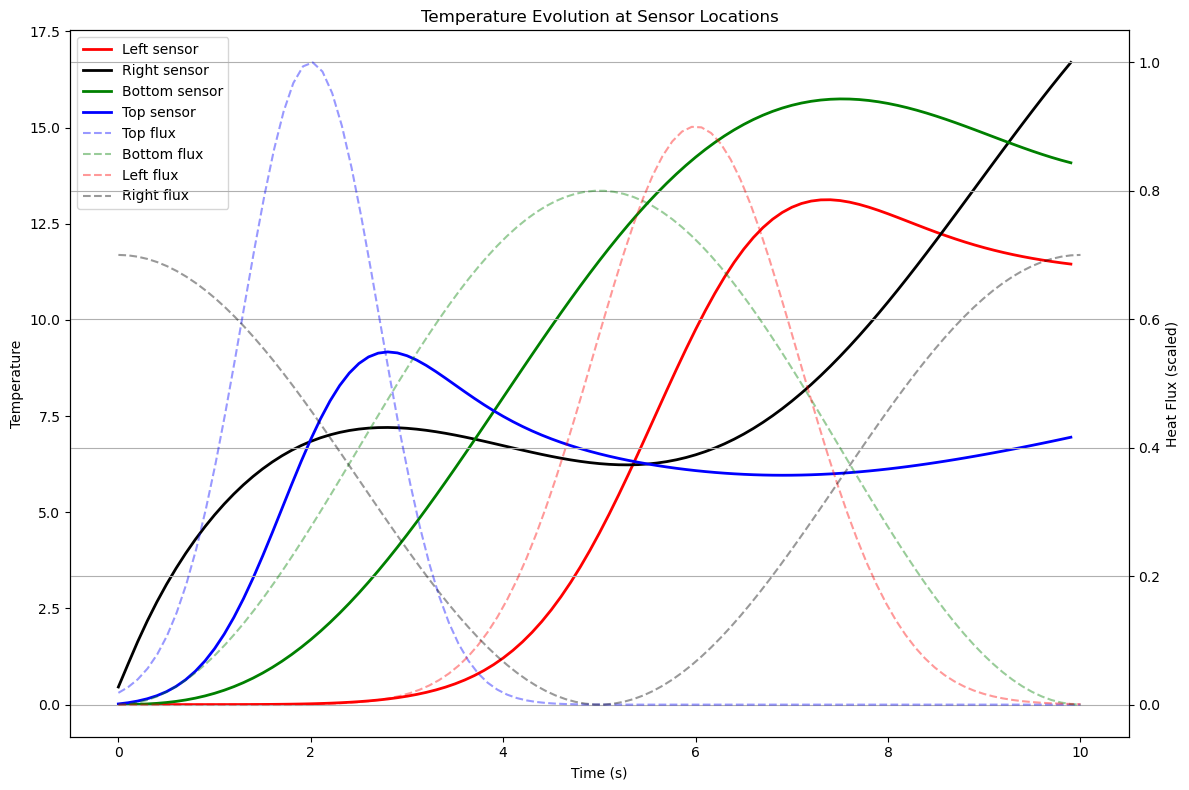

In [8]:

# Create time array
time_points = np.arange(0, T_end, dt)

# Create a figure
plt.figure(figsize=(12, 8))

# Plot temperature evolution at sensor locations
labels = ['Left sensor', 'Right sensor', 'Bottom sensor', 'Top sensor']
colors = ['r', 'k', 'g', 'b']

# Extract and plot data for each sensor
for i in range(4):
    plt.plot(time_points, sensor_data[:, i, 0], color=colors[i], label=labels[i], linewidth=2)

# Add heat flux functions to show their relationship with temperature changes
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot scaled versions of heat flux functions to overlay them
flux_scale = 1.0  # Scale factor to make the heat fluxes visible on the same scale
t_plot = np.linspace(0, T_end, 100)
ax2.plot(t_plot, [q_top(t) * flux_scale for t in t_plot], 'b--', alpha=0.4, label='Top flux')
ax2.plot(t_plot, [q_bottom(t) * flux_scale for t in t_plot], 'g--', alpha=0.4, label='Bottom flux')
ax2.plot(t_plot, [q_left(t) * flux_scale for t in t_plot], 'r--', alpha=0.4, label='Left flux')
ax2.plot(t_plot, [q_right(t) * flux_scale for t in t_plot], 'k--', alpha=0.4, label='Right flux')

# Add labels and title
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Temperature')
ax2.set_ylabel('Heat Flux (scaled)')
plt.title('Temperature Evolution at Sensor Locations')

# Add legends for both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.grid(True)
plt.tight_layout()
plt.show()

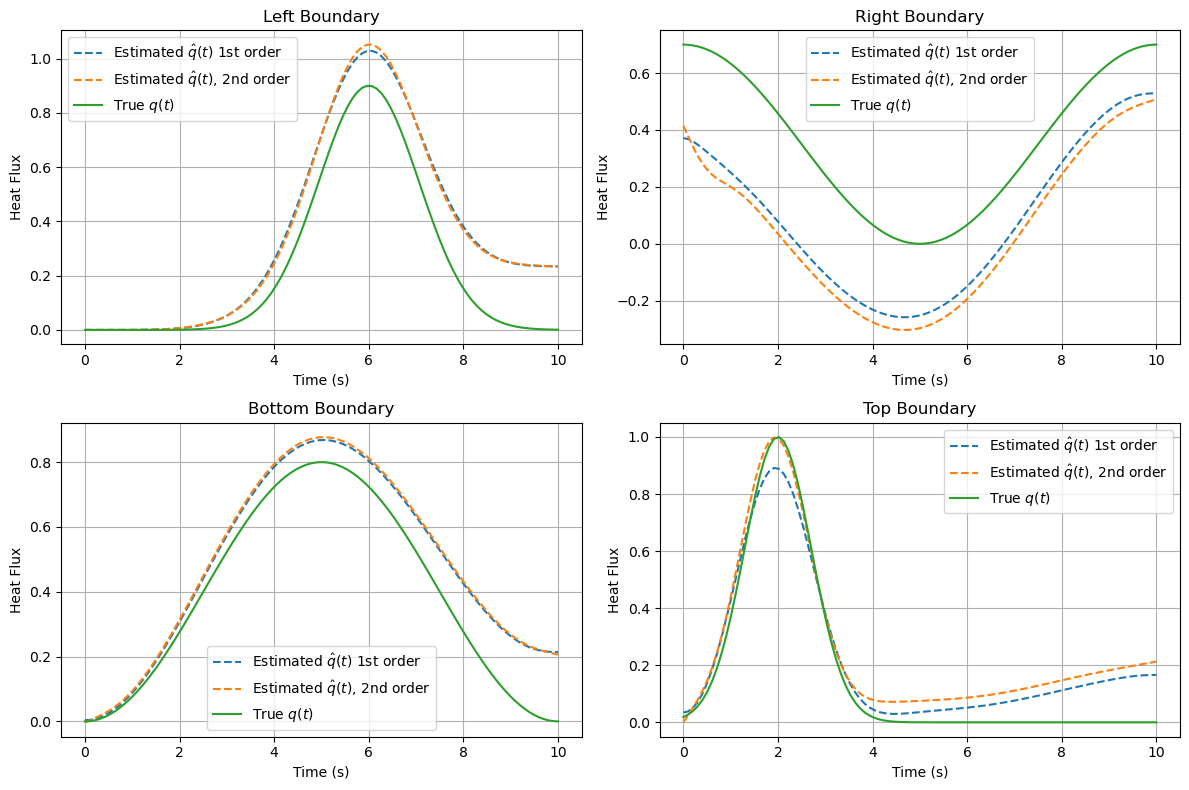

In [9]:
# Use sensor_data from the previous simulation
sensor_data = np.array(sensor_data)
num_time_steps = sensor_data.shape[0]
time_vec = np.linspace(0, T_end, num_time_steps)

# Parameters for 1D model
L = 1.0                          # Thickness (normalized domain length)
alpha = k                  # Thermal diffusivity, adjusted to match 2D sim
N = num_time_steps              # Number of time steps
t = time_vec                    # Time vector
x_sensor = 0.05                # Sensor location near boundary (within margin)

# Generate 1D sensitivity matrix
def generate_sensitivity_matrix(N, dt, L, alpha, x):
    t_dimless = alpha * np.arange(1, N + 1) * dt / L**2
    phi = np.zeros(N)
    for m in range(1, 101):
        bm = (m - 0.5) * np.pi
        phi += (np.cos(bm * x / L) / bm**2) * np.exp(-bm**2 * t_dimless)
    phi = 1 - x / L - 2 * phi
    X = np.zeros((N, N))
    for i in range(N):
        for j in range(i + 1):
            if j == 0:
                X[i, j] = phi[i]
            else:
                X[i, j] = phi[i - j] - phi[i - j - 1] if (i - j - 1) >= 0 else phi[i - j]
    return X

# Regularization matrix generator
def tikhonov_matrix(order, N):
    if order == 1:
        H = -np.eye(N) + np.diag(np.ones(N - 1), k=1)
        return H[:-1]
    elif order == 2:
        H = np.zeros((N - 2, N))
        for i in range(N - 2):
            H[i, i] = 1
            H[i, i + 1] = -2
            H[i, i + 2] = 1
        return H
    else:
        return np.eye(N)

# Generate sensitivity matrix
X = generate_sensitivity_matrix(N, dt, L, alpha, x_sensor)

# Regularization parameter and matrix
alpha_T = 0.01
H2 = tikhonov_matrix(order=2, N=N)
F_T2 = np.linalg.inv(X.T @ X + alpha_T * H2.T @ H2) @ X.T

# Solve IHCP for each sensor with 2nd-order Tikhonov regularization
q_estimates = []
for i in range(4):
    T_obs = sensor_data[:, i]
    q_est = F_T2 @ T_obs
    q_estimates.append(q_est)

# Add 1st-order Tikhonov regularization alternative for comparison
alpha_T1 = 0.01  # Regularization parameter for 1st order
H1 = tikhonov_matrix(order=1, N=N)
F_T1 = np.linalg.inv(X.T @ X + alpha_T1 * H1.T @ H1) @ X.T

# Solve IHCP for each sensor with 1st-order Tikhonov regularization
q_estimates_T1 = []
for i in range(4):
    T_obs = sensor_data[:, i]
    q_est_T1 = F_T1 @ T_obs
    q_estimates_T1.append(q_est_T1)

# Plot estimated vs. true flux for each side
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
labels = ["Left", "Right", "Bottom", "Top"]
true_flux_funcs = [q_left, q_right, q_bottom, q_top]

for i, ax in enumerate(axs.ravel()):
    ax.plot(t, q_estimates_T1[i]/100, label="Estimated $\\hat{q}(t)$ 1st order", linestyle='--')
    ax.plot(t, q_estimates[i]/100, label="Estimated $\\hat{q}(t)$, 2nd order", linestyle='--')
    ax.plot(t, [true_flux_funcs[i](ti) for ti in t], label="True $q(t)$")
    ax.set_title(f"{labels[i]} Boundary")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Heat Flux")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


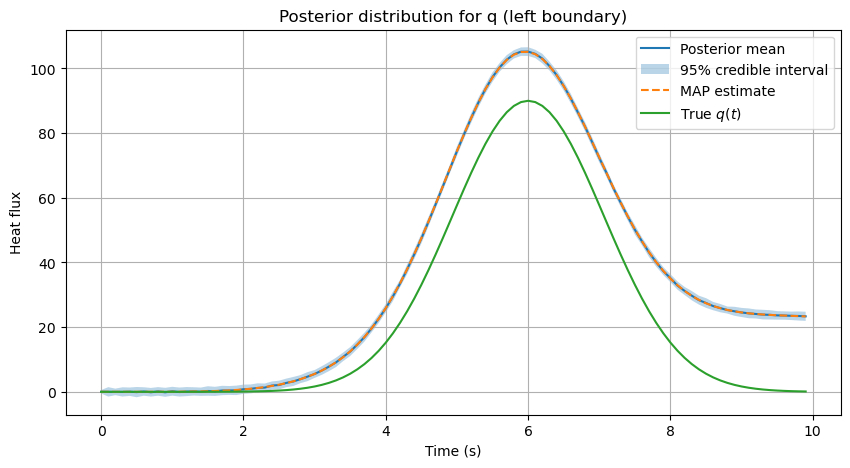

In [10]:

# For the left boundary as an example (index 0)
# X: sensitivity matrix (already defined in cell 7)
# H2: 2nd-order Tikhonov regularization matrix (already defined)
# alpha_T: regularization parameter (already defined)
# sensor_data: observed temperature at sensors (already defined)
# N: number of time steps (already defined)

# Choose which sensor (boundary) to analyze, e.g., left boundary (index 0)
sensor_idx = 0
T_obs = sensor_data[:, sensor_idx].flatten()

# Noise variance (assume known or estimate from data)
sigma2 = np.var(T_obs - X @ q_estimates[sensor_idx].flatten())  # or set a value, e.g., sigma2 = 1.0

# Prior covariance (Tikhonov)
prior_cov_inv = alpha_T * (H2.T @ H2)
prior_cov = np.linalg.inv(prior_cov_inv + 1e-8 * np.eye(N))  # add small value for numerical stability

# Posterior covariance and mean (MAP is already computed as q_estimates[sensor_idx])
A = X
post_cov_inv = (A.T @ A) / sigma2 + prior_cov_inv
post_cov = np.linalg.inv(post_cov_inv + 1e-8 * np.eye(N))
post_mean = post_cov @ (A.T @ T_obs / sigma2)

# The full posterior is N(post_mean, post_cov)
# Example: sample from the posterior
num_samples = 100
q_samples = np.random.multivariate_normal(post_mean, post_cov, size=num_samples)

# You can now analyze q_samples, e.g., compute credible intervals
q_mean = np.mean(q_samples, axis=0)
q_std = np.std(q_samples, axis=0)

# Plot posterior mean and 95% credible interval for the left boundary

plt.figure(figsize=(10, 5))
plt.plot(time_points, q_mean, label="Posterior mean")
plt.fill_between(time_points, q_mean - 2*q_std, q_mean + 2*q_std, alpha=0.3, label="95% credible interval")
plt.plot(time_points, q_estimates[sensor_idx].flatten(), '--', label="MAP estimate")
plt.plot(time_points, [true_flux_funcs[0](ti)*100 for ti in time_points], label="True $q(t)$")
plt.xlabel("Time (s)")
plt.ylabel("Heat flux")
plt.title("Posterior distribution for q (left boundary)")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Define functions that will interpolate the estimated heat flux values
def q_top_estimated(t_val):
    # Find the nearest time index in time_vec
    idx = min(range(len(time_vec)), key=lambda i: abs(time_vec[i] - t_val))
    # Return the corresponding estimated heat flux value (scaled down)
    return q_estimates[3][idx][0]/100

def q_bottom_estimated(t_val):
    idx = min(range(len(time_vec)), key=lambda i: abs(time_vec[i] - t_val))
    return q_estimates[2][idx][0]/100

def q_left_estimated(t_val):
    idx = min(range(len(time_vec)), key=lambda i: abs(time_vec[i] - t_val))
    return q_estimates[0][idx][0]/100

def q_right_estimated(t_val):
    idx = min(range(len(time_vec)), key=lambda i: abs(time_vec[i] - t_val))
    return q_estimates[1][idx][0]/100

In [13]:
t = 0.0
dt = 0.1
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# Setup linear system
A = fem.petsc.assemble_matrix(fem.form(a))
A.assemble()
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.CG)
solver.getPC().setType(PETSc.PC.Type.JACOBI)

sensor_data_estimated = []
# Time loop and sensor capture
T_all_estimated = []
T_estimated = fem.Function(V)
T_estimated_n = fem.Function(V)
T_estimated_n.name = "Temperature"
T_estimated_n.x.array[:] = 0.0  # Initial temperature

a = u * v * ufl.dx + dt * k * ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L_base = T_estimated_n * v * ufl.dx  # Base without Neumann terms

for step in range(num_steps):
    t += dt

    # Define time-dependent Neumann flux terms
    flux_form = (
         dt * q_top_estimated(t) * v * ds(1)
        + dt * q_bottom_estimated(t) * v * ds(2)
        + dt * q_left_estimated(t) * v * ds(3)
        + dt * q_right_estimated(t) * v * ds(4)
    )

    L = fem.form(L_base + flux_form)
    b = fem.petsc.assemble_vector(L)
    # fem.petsc.apply_lifting(b, [a], [[]]) 
    # b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, [])


    solver.solve(b, T_estimated.x.petsc_vec)
    T_estimated.x.scatter_forward()
    T_estimated_n.x.array[:] = T_estimated.x.array[:]

    # Store snapshot
    if step % 5 == 0 or step == num_steps - 1:
        T_all_estimated.append(T_estimated.copy())

    # Sensor values
    sensor_vals_estimated = [measure_sensor(p, T_estimated) for p in sensor_coords]
    sensor_data_estimated.append(sensor_vals_estimated)

# Extract for visualization
temperature_fields_estimated = [T_estimated.x.array[:] for T_estimated in T_all_estimated]
temperature_fields_estimated = np.array(temperature_fields_estimated)
sensor_data_estimated = np.array(sensor_data_estimated)
temperature_fields_estimated.shape, sensor_data_estimated.shape

((21, 2601), (100, 4, 1))

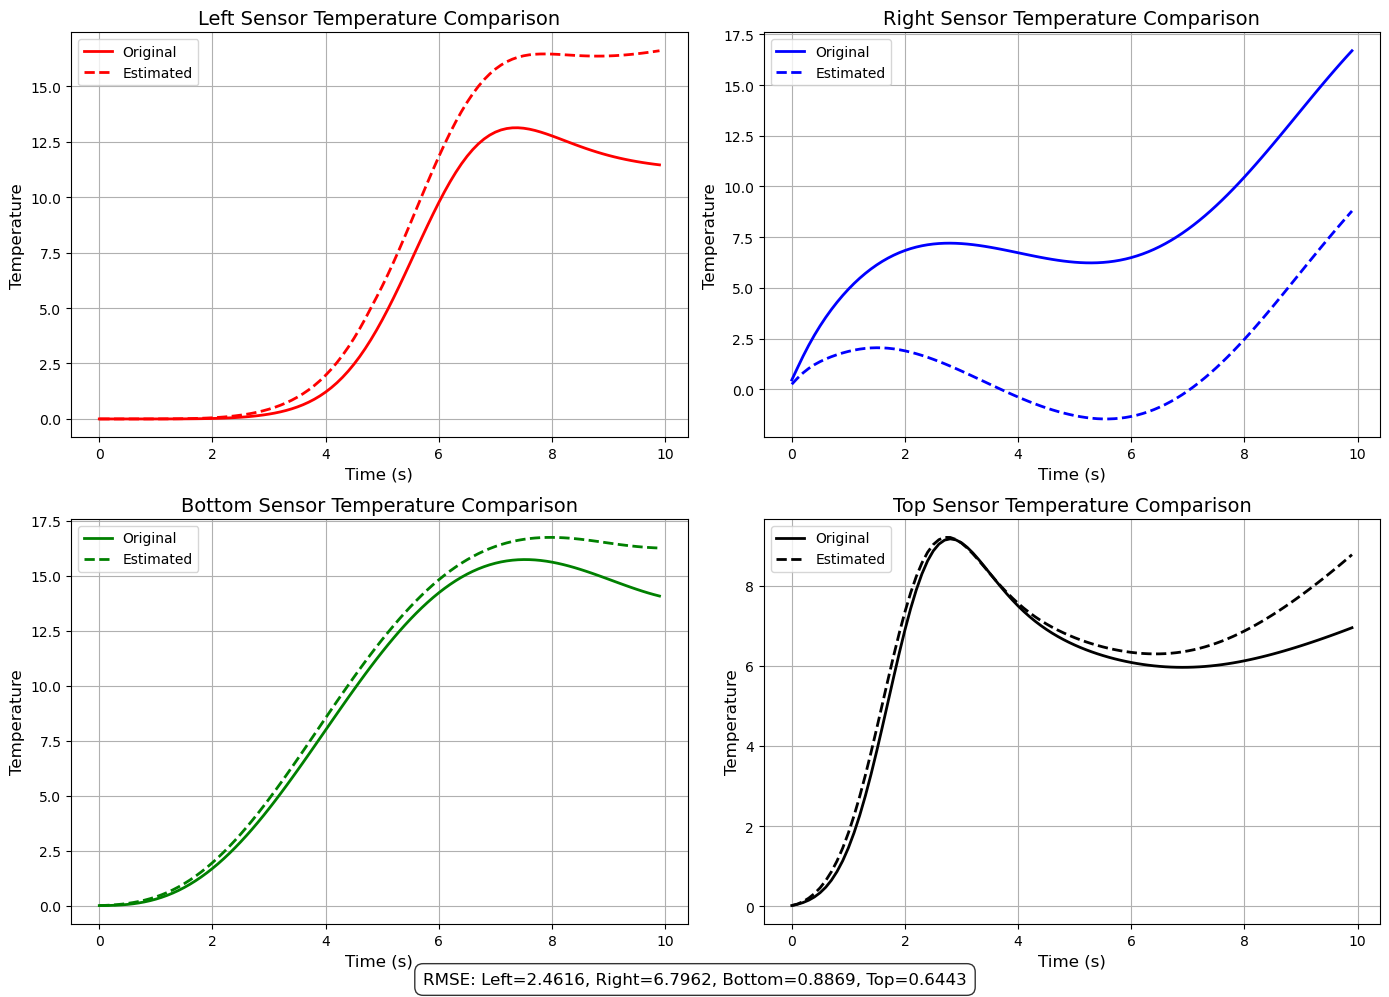

In [14]:

# Create a figure with 2x2 subplots for each sensor
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
sensor_names = ["Left", "Right", "Bottom", "Top"]
colors = ["r", "b", "g", "k"]

# Extract sensor data
original_sensor_data = sensor_data.reshape(num_steps, 4)
estimated_sensor_data = sensor_data_estimated.reshape(num_steps, 4)

# Plot each sensor's data
for i, (name, ax) in enumerate(zip(sensor_names, axs.flatten())):
    # Original data
    ax.plot(time_points, original_sensor_data[:, i], colors[i], label="Original", linewidth=2)
    
    # Estimated data
    ax.plot(time_points, estimated_sensor_data[:, i], colors[i] + "--", label="Estimated", linewidth=2)
    
    # Add labels and customize plot
    ax.set_title(f"{name} Sensor Temperature Comparison", fontsize=14)
    ax.set_xlabel("Time (s)", fontsize=12)
    ax.set_ylabel("Temperature", fontsize=12)
    ax.grid(True)
    ax.legend()

# Calculate error metrics
rmse_values = []
for i in range(4):
    rmse = np.sqrt(np.mean((original_sensor_data[:, i] - estimated_sensor_data[:, i])**2))
    rmse_values.append(rmse)

# Add a text box with error metrics
fig.text(0.5, 0.01, f"RMSE: Left={rmse_values[0]:.4f}, Right={rmse_values[1]:.4f}, "
         f"Bottom={rmse_values[2]:.4f}, Top={rmse_values[3]:.4f}", 
         ha='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(bottom=0.07)
plt.show()